In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from zipfile import ZipFile

In [ ]:
data_path = '/content/drive/MyDrive/archive.zip'

with ZipFile(data_path, 'r') as zip:
        zip.extractall()
        print('The dataset has been extracted.')

The dataset has been extracted.


In [ ]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_scc', 'lung_n', 'lung_aca']

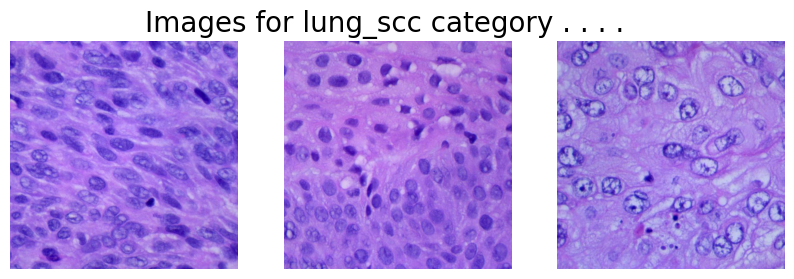

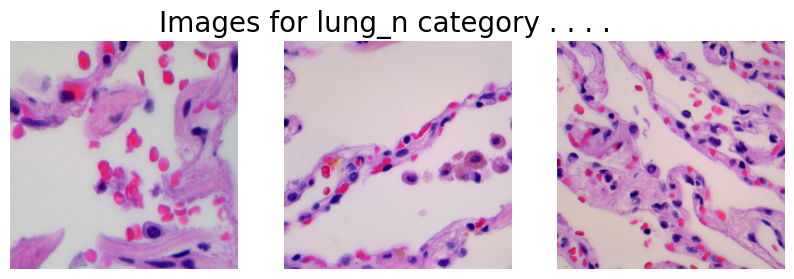

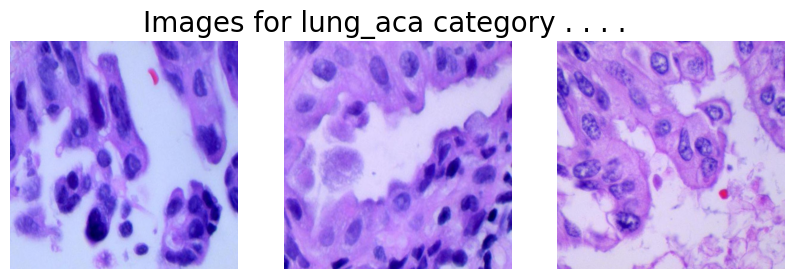

In [ ]:
path = '/content/lung_colon_image_set/lung_image_sets'
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(10, 3))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [ ]:
IMG_SIZE = 192
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 96


In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
      img = cv2.imread(image)

      X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
      Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 192, 192, 3) (3000, 192, 192, 3)


In [ ]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [ ]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
125/125 [==============================] - 774s 6s/step - loss: 0.3952 - accuracy: 0.8402 - val_loss: 225.2517 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 735s 6s/step - loss: 0.2369 - accuracy: 0.9033 - val_loss: 6.9686 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 734s 6s/step - loss: 0.1744 - accuracy: 0.9298 - val_loss: 9.9798 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 764s 6s/step - loss: 0.1437 - accuracy: 0.9437 - val_loss: 3.2530 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 730s 6s/step - loss: 0.0960 - accuracy: 0.9651 - val_loss: 3.9912 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9738
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 [==============================] - 731

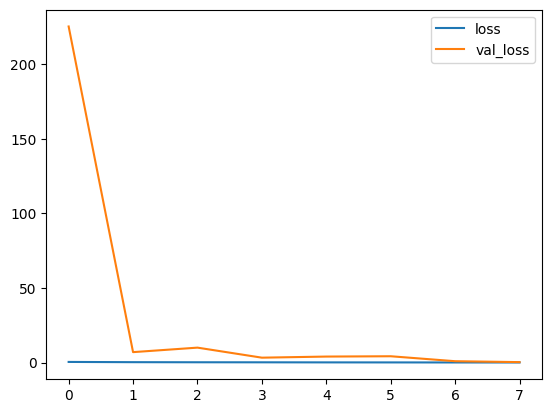

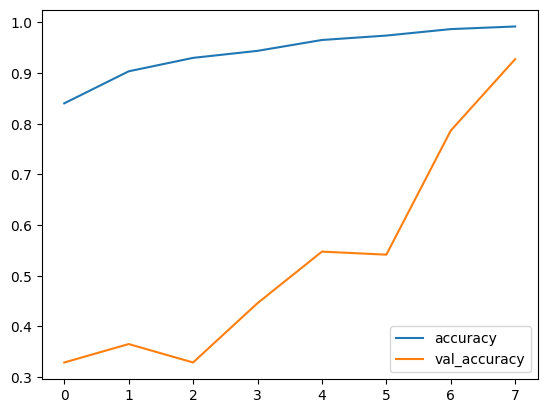

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 62s 656ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[944,   0,  43],
       [  0, 973,   4],
       [157,  14, 865]])

In [ ]:
model.save('/content/drive/MyDrive/model3.h5')
